## Libraries and Dependencies

In [1]:
import sys
sys.path.insert(0, './utils/')

import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import matplotlib.gridspec as gridspec
import warnings

from collections import OrderedDict
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable

warnings.filterwarnings('ignore')

np.random.seed(1234)

In [2]:
n_iter=10000

In [3]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:2')
else:
    device = torch.device('cpu')

In [4]:
device

device(type='cuda', index=2)

## Physics-informed Neural Networks

In [5]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [6]:
import torch
import numpy as np

# Define the Allen-Cahn physics-informed neural network (PINN) class
class PhysicsInformedNN():
    def __init__(self, X, u, layers, lb, ub):
        # Boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # Data
        self.x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        self.t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        # Settings
        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(device)
        self.lambda_2 = torch.tensor([-6.0], requires_grad=True).to(device)
        
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        
        # Deep neural networks
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('lambda_1', self.lambda_1)
        self.dnn.register_parameter('lambda_2', self.lambda_2)
        
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=n_iter, 
            max_eval=n_iter, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        # Optimizers
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        self.history = []

    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        lambda_1 = self.lambda_1        
        lambda_2 = torch.exp(self.lambda_2)
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        # Modify this part based on the Allen-Cahn equation
        f = u_t - lambda_1 * u_xx + lambda_2 * (u ** 3) - lambda_2 * u
        return f

    def loss_func(self):
        u_pred = self.net_u(self.x, self.t)
        f_pred = self.net_f(self.x, self.t)
        
        # Adjust the loss function based on the Allen-Cahn equation
        loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
        
        self.optimizer_Adam.zero_grad()
        loss.backward()
        self.history.append(loss.item())
        self.iter += 1
        # print(f"self.iter = {self.iter}")
        if self.iter % 100 == 0:
            print(
                'Loss: %e, l1: %.5f, l2: %.5f' % 
                (
                    loss.item(),
                    torch.exp(self.lambda_1.detach()).item(),
                    self.lambda_2.item()
                )
            )
        return loss
    
    def train(self, nIter):
        self.dnn.train()
        for epoch in range(nIter):
            u_pred = self.net_u(self.x, self.t)
            f_pred = self.net_f(self.x, self.t)
            
            # Adjust the loss function based on the Allen-Cahn equation
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            self.history.append(loss.item())
            if epoch % 100 == 0:
                print(
                    'It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f' % 
                    (
                        epoch, 
                        loss.item(), 
                        torch.exp(self.lambda_1).item(),
                        self.lambda_2.item()
                    )
                )
                
        self.optimizer.step(self.loss_func)
    
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

## Configurations

In [7]:
nu = 0.0001

N_u = 2000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('data/AC.mat')

t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['uu']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0) 

## Training on Non-noisy Data

In [8]:
%%time

noise = 0.0            

# create training set
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]

# training
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model.train(0)

Loss: 1.117847e-01, l1: 0.98021, l2: -5.99649
Loss: 6.123991e-02, l1: 0.99454, l2: -5.99668
Loss: 4.999816e-02, l1: 0.98691, l2: -5.99007
Loss: 4.658634e-02, l1: 0.98331, l2: -5.98256
Loss: 4.488572e-02, l1: 0.98132, l2: -5.97179
Loss: 4.347344e-02, l1: 0.98080, l2: -5.96378
Loss: 4.214781e-02, l1: 0.98000, l2: -5.95704
Loss: 4.144910e-02, l1: 0.97925, l2: -5.95210
Loss: 4.111565e-02, l1: 0.97966, l2: -5.94763
Loss: 4.086007e-02, l1: 0.97961, l2: -5.94167
Loss: 4.056465e-02, l1: 0.97984, l2: -5.93217
Loss: 4.032242e-02, l1: 0.97972, l2: -5.92190
Loss: 4.008853e-02, l1: 0.97943, l2: -5.91195
Loss: 3.990473e-02, l1: 0.97911, l2: -5.90728
Loss: 3.977703e-02, l1: 0.97949, l2: -5.90045
Loss: 3.957911e-02, l1: 0.97930, l2: -5.88449
Loss: 3.945298e-02, l1: 0.97937, l2: -5.87962
Loss: 3.935505e-02, l1: 0.97951, l2: -5.87351
Loss: 3.927169e-02, l1: 0.97951, l2: -5.86702
Loss: 3.912736e-02, l1: 0.97972, l2: -5.85329
Loss: 3.902698e-02, l1: 0.97993, l2: -5.84677
Loss: 3.894401e-02, l1: 0.97985, l

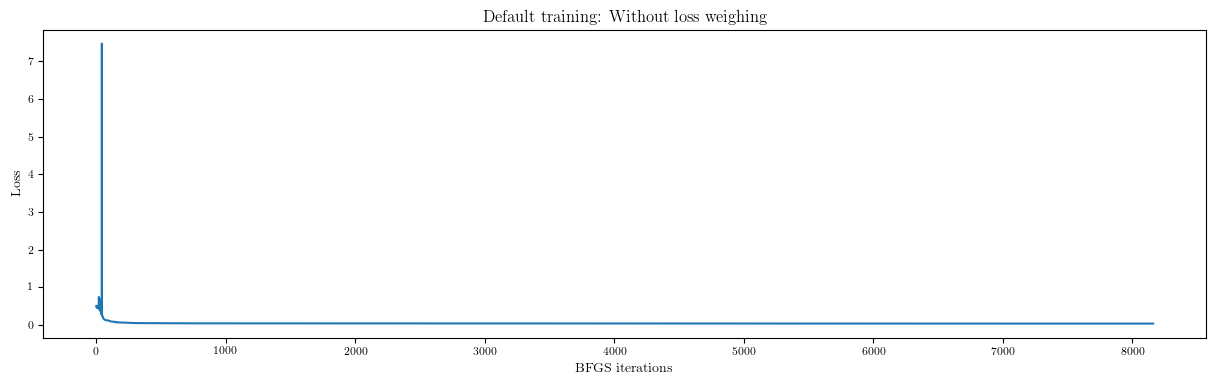

In [9]:
plt.figure(figsize=(15,4))
plt.title("Default training: Without loss weighing")
plt.xlabel("BFGS iterations")
plt.ylabel("Loss")
plt.plot(model.history)

In [10]:
# evaluations
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

lambda_1_value = model.lambda_1.detach().cpu().numpy()
lambda_2_value = model.lambda_2.detach().cpu().numpy()
lambda_1_value = np.exp(lambda_1_value)

error_lambda_1 = np.abs(lambda_1_value - nu) * 100
error_lambda_2 = np.abs(lambda_2_value - 5.0) * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))  

Error u: 2.610683e-01
Error l1: 98.01003%
Error l2: 1006.07452%


In [11]:
torch.save(model, 'allen_cahn_no_wt.pth')

## Training on Noisy Data

In [12]:
noise = 0.01    

# create training set
u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

# training
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model.train(0)            

Loss: 9.589070e-02, l1: 0.99852, l2: -6.00463
Loss: 6.156944e-02, l1: 0.99642, l2: -6.00127
Loss: 5.259762e-02, l1: 0.98692, l2: -5.99272
Loss: 4.769026e-02, l1: 0.98312, l2: -5.98629
Loss: 4.536008e-02, l1: 0.98182, l2: -5.98126
Loss: 4.404528e-02, l1: 0.98146, l2: -5.97067
Loss: 4.291133e-02, l1: 0.97986, l2: -5.95467
Loss: 4.142430e-02, l1: 0.97998, l2: -5.93983
Loss: 4.043712e-02, l1: 0.97961, l2: -5.92996
Loss: 4.000084e-02, l1: 0.97940, l2: -5.92480
Loss: 3.966123e-02, l1: 0.97913, l2: -5.91584
Loss: 3.940082e-02, l1: 0.97961, l2: -5.90701
Loss: 3.922923e-02, l1: 0.97995, l2: -5.89936
Loss: 3.898545e-02, l1: 0.97954, l2: -5.88458
Loss: 3.877050e-02, l1: 0.97973, l2: -5.86960
Loss: 3.850674e-02, l1: 0.97985, l2: -5.85456
Loss: 3.818549e-02, l1: 0.97978, l2: -5.83043
Loss: 3.786390e-02, l1: 0.98001, l2: -5.80442
Loss: 3.757016e-02, l1: 0.97994, l2: -5.79080
Loss: 3.733412e-02, l1: 0.98011, l2: -5.77133
Loss: 3.718489e-02, l1: 0.98022, l2: -5.76360
Loss: 3.701047e-02, l1: 0.98022, l

## Visualizations

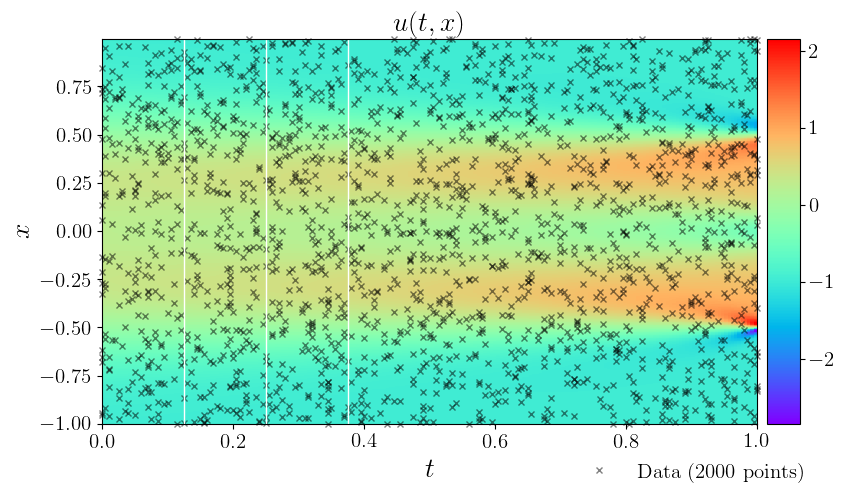

In [13]:

""" The aesthetic setting has changed. """

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=.5
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

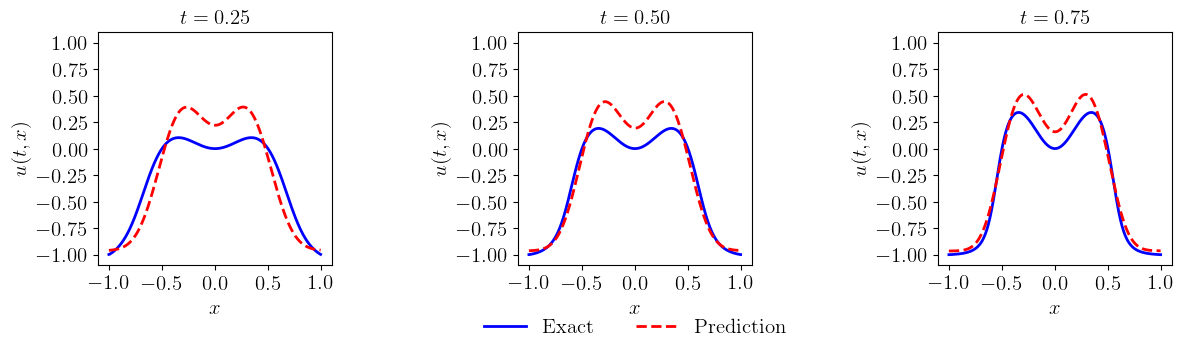

In [14]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

In [15]:
# evaluations
u_pred, f_pred = model.predict(X_star)

lambda_1_value_noisy = model.lambda_1.detach().cpu().numpy()
lambda_2_value_noisy = model.lambda_2.detach().cpu().numpy()
lambda_2_value_noisy = np.exp(lambda_2_value_noisy)

error_lambda_1_noisy = np.abs(lambda_1_value_noisy - nu) * 100
error_lambda_2_noisy = np.abs(lambda_2_value_noisy - 5.0) * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1_noisy))                             
print('Error l2: %.5f%%' % (error_lambda_2_noisy))    

Error u: 2.610683e-01
Error l1: 2.00830%
Error l2: 499.54843%


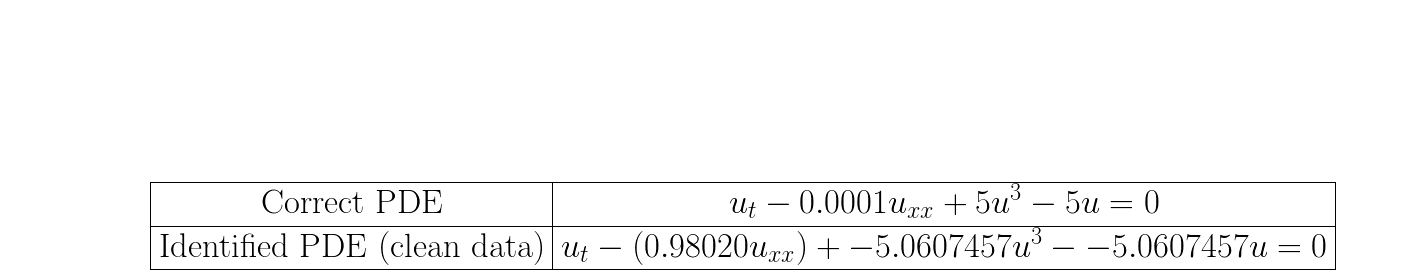

In [16]:
####### Row 3: Identified PDE ##################    

fig = plt.figure(figsize=(14, 10))

gs2 = gridspec.GridSpec(1, 3)
gs2.update(top=0.25, bottom=0, left=0.0, right=1.0, wspace=0.0)

ax = plt.subplot(gs2[:, :])
ax.axis('off')

s1 = r'$\begin{tabular}{ |c|c| }  \hline Correct PDE & $u_t - 0.0001 u_{xx} + 5 u^3 − 5 u = 0$ \\  \hline Identified PDE (clean data) & '
s2 = r'$u_t - (%.5f u_{xx}) + %.7f u^3 - %.7f u = 0$ \\  \hline ' % (lambda_1_value, lambda_2_value, lambda_2_value)
s3 = r'Identified PDE (1\% noise) & '
# s4 = r'$u_t + %.5f u u_x - %.7f u_{xx} = 0$  \\  \hline ' % (lambda_1_value_noisy, lambda_2_value_noisy)
s5 = r'\end{tabular}$'
s = s1+s2+s5
ax.text(0.1, 0.1, s, size=25)

plt.show()

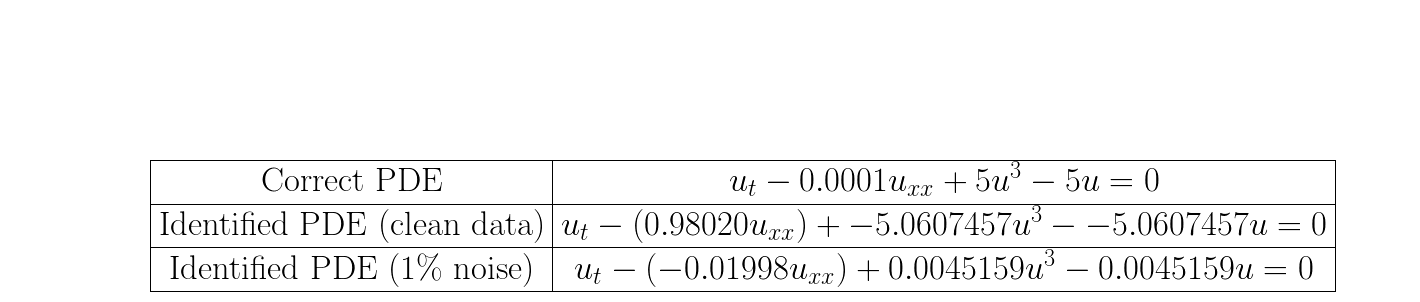

In [17]:
####### Row 3: Identified PDE ##################    

fig = plt.figure(figsize=(14, 10))

gs2 = gridspec.GridSpec(1, 3)
gs2.update(top=0.25, bottom=0, left=0.0, right=1.0, wspace=0.0)

ax = plt.subplot(gs2[:, :])
ax.axis('off')

s1 = r'$\begin{tabular}{ |c|c| }  \hline Correct PDE & $u_t - 0.0001 u_{xx} + 5 u^3 − 5 u = 0$ \\  \hline Identified PDE (clean data) & '
s2 = r'$u_t - (%.5f u_{xx}) + %.7f u^3 - %.7f u = 0$ \\  \hline ' % (lambda_1_value, lambda_2_value, lambda_2_value)
s3 = r'Identified PDE (1\% noise) & '
s4 = r'$u_t - (%.5f u_{xx}) + %.7f u^3 - %.7f u = 0$  \\  \hline ' % (lambda_1_value_noisy, lambda_2_value_noisy, lambda_2_value_noisy)
s5 = r'\end{tabular}$'
s = s1+s2+s3+s4+s5
ax.text(0.1, 0.1, s, size=25)

plt.show()